In [135]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as an
import math
from scipy import linalg as la

import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.offline as py
import plotly.figure_factory as ff
mass = 4 # kg

# Dynamics

In [2]:
%%latex
The discretized form is
$$x(k+1)=A_d x(k) + B_d u(k)$$

$$A_d = e^{A \Delta t}, B_d = \int_{t=0}^{\Delta t} e^{At}\frac{B}{m}dt$$
$$A_d = \begin{bmatrix}
4-3 cos(n \Delta t) & 0 & \frac{1}{n}sin(n \Delta t) & \frac{2}{n}(1-cos(n \Delta t)) \\
6(sin(n \Delta t) - n \Delta t) & 1 & -\frac{2}{n}(1 - cos(n \Delta t)) & \frac{1}{n}(4sin(n \Delta t) - 3 n \Delta t) \\
3 n sin(n \Delta t) & 0 & cos(n \Delta t) & 2 sin(n \Delta t) \\
-6n(1-cos(n \Delta t)) & 0 & -2 sin(n \Delta t) & 4 cos(n \Delta t) - 3 \\
\end{bmatrix}$$

$$B_d = \frac{f_{thr}}{m}\begin{bmatrix}
\frac{1}{n^2}(1-cos(n \Delta t)) & \frac{2}{n^2}(n \Delta t - sin(n \Delta t )) \\
-\frac{2}{n^2}(n \Delta t - sin(n \Delta t )) & \frac{4}{n^2}(1-cos(n \Delta t)) - \frac{3}{2} \Delta t^2 \\
\frac{1}{n}sin(n \Delta t) & \frac{2}{n}(1-cos(n \Delta t)) \\
-\frac{2}{n}(1-cos(n \Delta t)) & \frac{4}{n}sin(n \Delta t)- 3\Delta t
\end{bmatrix}$$

The above is taken from Jewison, pages 66-69.

<IPython.core.display.Latex object>

In [3]:
class Base(object):
    def __init__(self, r0 = 300000, deltaT = 1, fmax=1, mass = 4):
        self.cg = 3.9886e14
        self.rknot = r0
        self.mu1 = np.sqrt(self.cg/self.rknot**3)
        print(self.mu1, self.cg, self.rknot)
        self.deltaT = deltaT
        ndelt = self.mu1*deltaT
        sin = np.sin(self.mu1*deltaT )
        cos = np.cos(self.mu1*deltaT )
        self.fmax = fmax
        self.mass = mass

        self.Ad = np.array([[4-3*cos,           0,      1/self.mu1*cos,         2/self.mu1*(1-cos)          ],
                            [6*(sin-ndelt),     1,      -2/self.mu1*(1-cos),     1/self.mu1*(4*sin -3 *ndelt)],
                            [3*self.mu1*sin,    0,      cos,                    2*sin],
                            [6*(1-cos),        0,      -2*sin,                 4*cos-3]])


        invn = 1/self.mu1
        insqr = self.mu1**(-2)
        self.Bd = fmax/mass * np.array([[insqr*(1-cos),         2*insqr*(ndelt-sin)],
                            [-2*insqr*(ndelt-sin),  4*insqr*(1-cos)-3/2*deltaT**2],
                            [insqr*sin,             2*insqr*(1-cos)],
                            [-2*insqr*(1-cos),       4*insqr*sin - 3 * deltaT]])

#         print(self.Ad)
#         print(self.Bd)



class Chaser(Base):
    def __init__(self, r0=300000, deltaT=1):
        Base.__init__(self, r0,deltaT)

# Spiral

In [4]:
class ArchimedesSpiral(object):
    def __init__(self, r0, rf, w, theta0, b, c, delta):
        self.r0 = r0 # starting radius
        self.rf = rf # final radius, docking port
        self.w = w # omega spin rate
        self.theta0 = theta0
        self.b = b 
        self.c = c
        self.tf = np.power((r0 - rf)/b, c)/w # final time
#         print(r0, rf, w, theta0, b, c, delta, self.tf)
#         print(self.tf)
        self.dt = delta
        self.t = np.arange(0, self.tf, delta )
        self.H = self.t.size # number of steps
        if self.tf >= self.dt:
            self.t[0] = self.t[1]
        else:
            raise ValueError('tf is less than dt')
        self.rt = r0 - b*np.power(w*self.t, 1/c)
        self.angle = self.t * w + theta0
        self.cos = np.cos(self.angle)
        self.sin = np.sin(self.angle)
        self.x = self.rt * self.cos
        self.y = self.rt * self.sin
        self.dR = -b*w/c*np.power(w*self.t, 1/c -1)
        self.xdot = self.dR * self.cos - w * self.rt * self.sin
        self.ydot = self.dR * self.sin + w * self.rt * self.cos
        
        # docking port position and vel over time
        self.xport = rf * self.cos
        self.yport = rf * self.sin
        self.xdotport = - rf * self.sin * w
        self.ydotport = rf * self.cos * w
        
        
        self.dRx = np.zeros((2,self.H)) # for plotting
        self.dRy = np.zeros((2,self.H)) # for plotting
        self.vscale = 5
        self.ascale = 50
        

        self.dRx[1,:] = self.vscale * (self.dR * self.cos - w * self.rt * self.sin) + self.x # scaled x velocity
        self.dRy[1,:] = self.vscale * (self.dR * self.sin + w * self.rt * self.cos) + self.y # scaled y velocity
        self.dRx[0,:] = self.x # x velocity
        self.dRy[0,:] = self.y # y velocity

        self.aLin = b*w**2/c*(1/c-1)*np.power(w*self.t, 1/c -2)

        self.ddRx = self.aLin * self.cos - w*self.dR*self.sin -w*self.dR*self.sin - w**2 * self.rt * self.cos # x accel
        self.ddRy = self.aLin * self.sin + w*self.dR*self.cos +w*self.dR*self.cos - w**2 * self.rt * self.sin # y accel
#         print("shape: ", self.ddRy.shape)
        self.xa = np.zeros((2,self.H))
        self.ya = np.zeros((2,self.H))

        self.xa[1,:] = self.ascale * self.ddRx # scaled x acceleration
        self.ya[1,:] = self.ascale * self.ddRy # scaled y acceleration
        self.xa += self.x
        self.ya += self.y
        
        self.reftraj = np.zeros((self.H, 6))
        self.reftraj[:,0] = self.x
        self.reftraj[:,1] = self.y
        self.reftraj[:,2] = self.dR * self.cos - w * self.rt * self.sin
        self.reftraj[:,3] = self.dR * self.sin + w * self.rt * self.cos
        self.reftraj[:,4] = self.ddRx
        self.reftraj[:,5] = self.ddRy

    def showSpiral(self):
        plt.figure(figsize=[4,4])
        plt.plot(self.x,self.y)
        plt.xlim(-5/4* self.r0, 5/4*self.r0)
        plt.ylim(-5/4* self.r0, 5/4*self.r0)
        plt.grid()
        plt.show()

Display an Example Spiral

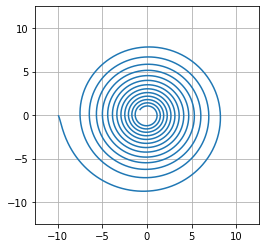

[ 5.22914897  6.05441996 -6.21783087  5.03994834 -4.87117408 -6.40489185]


In [5]:
r0 = 10
rf = 1
w = 1.0
c = 2
b = 1
H =10000
dt = 0.01
theta0 = math.pi
spiral = ArchimedesSpiral(r0, rf, w, theta0, b, c, dt)
spiral.showSpiral()
# print(spiral.ddRx.shape)
# chaser = Chaser(deltaT = 0.01)
# print(spiral.dt)
print(spiral.reftraj[400,:])

# Feasibility Check and Cost Calculation

In [6]:
def checkFeasibility(spiral, fmax, deltavmax):
    # checks if a spiral is feasible 
    ##### INPUTS:
    # spiral
    # fmax: float defining the max uniform accel
    # deltav: float, how much deltav (fuel) is available
    a = [np.array([[spiral.ddRx[i]], [spiral.ddRy[i]]]) for i in range(spiral.H)]
    a = np.squeeze(np.array(a))
    anorm = np.linalg.norm(a, axis=1)
    
    # calculate deltav of the spiral
    deltav = np.sum(anorm) * spiral.dt

    # calculate max acceleration of the spiral
    amax = np.amax(np.abs(anorm))
    
    if amax < fmax and deltav < deltavmax:
        return True, True, deltav
    elif amax < fmax and deltav >= deltavmax:
        return True, False, deltav
    elif amax >= fmax and deltav < deltavmax:
        return False, True, deltav
    else:
        return False, False, deltav

def calculateCost(spiral, fmax, deltavmax, xi):
    # calculates the cost of a spiral trajectory based on the cost function in Coauthor
    ##### INPUTS:
    # spiral
    # fmax: float defining the max uniform accel
    # deltav: float, how much deltav (fuel) is available
    
    afeas, vfeas, deltav = checkFeasibility(spiral, fmax, deltavmax)
    venorm = np.linalg.norm(spiral.reftraj[1,2:4] - xi[3:,0])
    Q = 0
    if not afeas:
        Q = 10000 
    F = -deltavmax
    
    return venorm + deltav + F + Q

Check the feasibility of a spiral

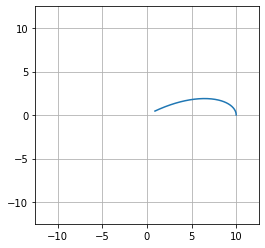

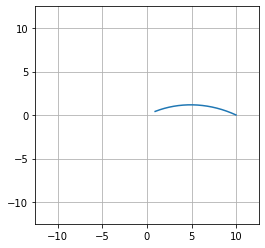

(True, True, 1.820578209814748)
cost:  -0.07833762790038357


In [7]:
# Spiral A
r0a = 10
rfa = 1
wa = 0.2
ca = 0.5
ba = 40
theta0 = 0
dta = 0.01
spirala = ArchimedesSpiral(r0a, rfa, wa, theta0, ba, ca, dta)
spirala.showSpiral()
deltava = 2
fmaxa = 1
# print(checkFeasibility(spirala, fmaxa, deltava))

# Spiral B
r0b = 10
rfb = 1
wb = 0.1
cb = 1
bb = 21
dtb = 0.01
spiralb = ArchimedesSpiral(r0b, rfb, wb, theta0, bb, cb, dtb)
spiralb.showSpiral()
deltavb = 2
fmaxb = 1
print(checkFeasibility(spiralb, fmaxb, deltavb))
# print(max(spirala.reftraj[:,3]))

xi = np.array([
    [0.1],
    [10],
    [0],
    [-2],
    [1]
])
print("cost: ", calculateCost(spiralb, fmaxb, deltavb, xi))

# Discretization



Starting with the continuous space, $\mathcal{S} = \{ \begin{bmatrix} 
\omega \\
x \\
y\\
\dot x\\
\dot y
\end{bmatrix} \}$, we can discretize the space into $\mathcal{\bar S} = \{ \xi_{N_d} \}$ with $\xi = \begin{bmatrix} 
\omega \\
x \\
y\\
\dot x\\
\dot y
\end{bmatrix}$
$$\xi_{\omega}= linspace(\omega_{min}, \omega_{max}, N_w)$$
$$\xi_x = linspace(-x_{max}, x_{max}, N_x)$$
$$\xi_y = linspace(-y_{max}, y_{max}, N_y)$$
$$\xi_{\dot x} = linspace(- \dot x_{max}, \dot x_{max}, N_{xd})$$
$$\xi_{\dot y} = linspace(-\dot y_{max}, \dot y_{max}, N_{yd})$$

Our actions are the parameters of the Archimedes Spiral trajectory that are free to determine given our state ($r_0$ and $\xi$ are already determined by the state):
$$\mathcal{A} = \{\begin{bmatrix}b \\ c \\ abort\end{bmatrix} \}$$

We discretize the action space into
$$\mathcal{\bar A} = \{\begin{bmatrix}b \\ c \\ abort\end{bmatrix} \}$$
$$b = linspace(0, b_{max}, N_b)$$
$$c = linspace(0, c_{max}, N_c)$$


Our policy at each discretized state is the one that minimizes some cost function, $J$:
$$\bar\Pi(\xi) = \argmin\limits_{b,c, \text{abort}} Q_{p} + F_p + R \Delta v ^2 $$
$$\argmin\limits_b$$
$$ Q_p = 10,000 \\Q_p := \text{large penalty for exceeding $a_{max}$, a positive value}\\
\text{$F_p$ is a reward for feasible trajectories, a negative value}$$
$$F_p = \begin{cases}- \Delta v_{max}^2 - 1 & \text{if feasible}\\
0 & \text{otherwise}
\end{cases}
$$
$$R = 1$$
The structure of this function is such that the following is true:
$$\begin{cases} 
J<0 & \text{feasible} \\
J\ge 0 & \text{abort}\end{cases}$$

In [8]:
##### Discretize the states #####
fmax = 1 # max force in the chaser's x and y frame
deltavmax = 2 # max deltav for the rendezvous
mass = 4 # mass of the chaser, kg
rf = 1 # final radius, the radius of the docking port
dt = 0.01

Nw = 1 # number of omega points to discretize to
Nx = 9 # number of x points to discretize to
Ny = 1 # number of y points to discretize to
Nxd = 9 # number of xdot points to discretize to 
Nyd = 9 # number of ydot points to discretize to
wmin = 0.1 # min angular velocity, rad/s
wmax = 0.1 # max angular velocity, rad/s
xmin = 2.0
xmax = 10.0
ymin = 0
ymax = 0
xdotmin = -2.0
xdotmax = 2.0
ydotmin = -2.0
ydotmax = 2.0

##### Toy numbers for debugging
# Nw = 1 # number of omega points to discretize to
# Nx = 10 # number of x points to discretize to
# Ny = 10 # number of y points to discretize to
# Nxd = 10 # number of xdot points to discretize to 
# Nyd = 10 # number of ydot points to discretize to
# wmin = 0.1 # min angular velocity, rad/s
# wmax = 0.1 # max angular velocity, rad/s
# xmin = 5.0
# xmax = 10.0
# ymin = 5.0
# ymax = 10.0
# xdotmin = -5.0
# xdotmax = 5.0
# ydotmin = -1.0
# ydotmax = 1.0

wdis = np.linspace(wmin, wmax, Nw)
xdis = np.linspace(xmin, xmax, Nx)
ydis = np.linspace(ymin, ymax, Ny)
xdotdis = np.linspace(xdotmin, xdotmax, Nxd)
ydotdis = np.linspace(ydotmin, ydotmax, Nyd)




Xi = np.zeros((Nw, Nx, Ny, Nxd, Nyd, 2), dtype='uint8') 

# Xi[:,:,:,:,:,0] := the index of b if feasible, -1 otherwise
# Xi[:,:,:,:,:,1] := the index of c if feasible, -1 otherwise

# IMPORTANT: the index of b and c are stored as uint8, meaning an unsigned int from 0 to 255
# 255 is reserved for "abort" 
# therefore, the following must be true: Nb < 254 and Nc < 254

##### Discretize the parameter space in b and c #####
bmin = 1
bmax = 50
cmin = 0.1
cmax = 2.0
Nb = 50
Nc = 10

##### TOY VALUES FOR DEBUGGING
# bmin = 20
# bmax = 20
# cmin = 1
# cmax = 2
# Nb = 1
# Nc = 2

bdis = np.linspace(bmin, bmax, Nb)
cdis = np.linspace(cmin, cmax, Nc)**2
# cdis[0] = 0.1
print("b")
print(bdis)
print("c")
print(cdis)

print("Dimensionality of the state space: ", wdis.shape[0] * xdis.shape[0] * ydis.shape[0] * xdotdis.shape[0] * ydotdis.shape[0])
print("Dimensionality of the parameter space: ", Nb * Nc)
print("Dimensionality of the map: ", wdis.shape[0] * xdis.shape[0] * ydis.shape[0] * xdotdis.shape[0] * ydotdis.shape[0] * Nb * Nc)
print(wdis)
print(xdis)
print(ydis)
print(xdotdis)
print(ydotdis)

b
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35. 36.
 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50.]
c
[0.01       0.09679012 0.27271605 0.53777778 0.89197531 1.33530864
 1.86777778 2.48938272 3.20012346 4.        ]
Dimensionality of the state space:  729
Dimensionality of the parameter space:  500
Dimensionality of the map:  364500
[0.1]
[ 2.  3.  4.  5.  6.  7.  8.  9. 10.]
[0.]
[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]
[-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]


This searches the discretized state for the best b, c, abort combos for each state $\xi$

In [86]:
for iw in range(Nw):
    for ix in range(Nx):
        for iy in range(Ny):
            for ixd in range(Nxd):
                for iyd in range(Nyd):
                    mincost = 0
                    for ib in range(Nb):
                        for ic in range(Nc):
                            # for every element in the discretized state
                            r = np.sqrt(xdis[ix]**2 + ydis[iy]**2)
                            if r < rf:
                                continue
                            angle = np.arctan2(ydis[iy], xdis[ix])
                            try:
                                spiral = ArchimedesSpiral(r, rf, wdis[iw], angle, bdis[ib], cdis[ic], dt) # create the spiral
                            except ValueError:
#                                 print("Value Error! Replacing ", Xi[iw, ix, iy, ixd, iyd, 0])
#                                 Xi[iw, ix, iy, ixd, iyd, 0] = 255
#                                 Xi[iw, ix, iy, ixd, iyd, 1] = 255
                                continue
                            xi = np.array([
                                [wdis[iw]],
                                [xdis[ix]],
                                [ydis[iy]],
                                [xdotdis[ixd]],
                                [ydotdis[iyd]]
                            ])
                            cost = calculateCost(spiral, fmax, deltavmax, xi)
                            if cost < mincost:
                                mincost = cost
#                                 print(mincost)
                                Xi[iw, ix, iy, ixd, iyd, 0] = ib
                                Xi[iw, ix, iy, ixd, iyd, 1] = ic
                                print("WE GOT A WINNER: ", [iw, ix, iy, ixd, iyd, ib, ic])
#                     print(mincost)
                    if mincost == 0:
                        Xi[iw, ix, iy, ixd, iyd, 0] = 255
                        Xi[iw, ix, iy, ixd, iyd, 1] = 255
                    else:
                        print(Xi[iw, ix, iy, ixd, iyd, 0], Xi[iw, ix, iy, ixd, iyd, 1])


np.save('Xi_4.npy', Xi)


WE GOT A WINNER:  [0, 0, 0, 1, 3, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 1, 4, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 1, 4, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 1, 5, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 1, 5, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 1, 6, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 2, 2, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 2, 2, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 2, 3, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 2, 3, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 2, 4, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 2, 4, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 2, 5, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 2, 5, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 2, 6, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 2, 6, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 2, 7, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 2, 7, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 3, 1, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 3, 2, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 3, 2, 0, 3]
0 3
WE GOT A WINNER:  [0, 0, 0, 3, 3, 0, 0]
WE GOT A WINNER:  [0, 0, 0, 3, 3, 0, 2]
WE GOT A WINNER:  [0, 0, 0, 3, 3

1 3
WE GOT A WINNER:  [0, 2, 0, 6, 5, 0, 2]
WE GOT A WINNER:  [0, 2, 0, 6, 5, 0, 3]
WE GOT A WINNER:  [0, 2, 0, 6, 5, 1, 3]
1 3
WE GOT A WINNER:  [0, 2, 0, 6, 6, 0, 3]
WE GOT A WINNER:  [0, 2, 0, 6, 6, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 2, 4, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 2, 5, 0, 3]
WE GOT A WINNER:  [0, 3, 0, 2, 5, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 2, 6, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 3, 3, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 3, 4, 0, 2]
WE GOT A WINNER:  [0, 3, 0, 3, 4, 0, 3]
WE GOT A WINNER:  [0, 3, 0, 3, 4, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 3, 5, 0, 2]
WE GOT A WINNER:  [0, 3, 0, 3, 5, 0, 3]
WE GOT A WINNER:  [0, 3, 0, 3, 5, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 3, 6, 0, 2]
WE GOT A WINNER:  [0, 3, 0, 3, 6, 0, 3]
WE GOT A WINNER:  [0, 3, 0, 3, 6, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 3, 7, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 4, 3, 0, 3]
WE GOT A WINNER:  [0, 3, 0, 4, 3, 1, 3]
1 3
WE GOT A WINNER:  [0, 3, 0, 4, 4, 0, 2]
WE GOT A WINNER:  [0, 3, 0, 4, 4

Use the following function to load a saved result from the search

In [101]:
Xid = np.load('Xi_3.npy')
print(Xid[0, 8, 0, 4, 6, 0])

3


Output the feasible discretized trajectories as a list

In [10]:
trajs = []
for iw in range(Nw):
    for ix in range(Nx):
        for iy in range(Ny):
            for ixd in range(Nxd):
                for iyd in range(Nyd):
                    if Xid[iw, ix, iy, ixd, iyd, 0] != 255:
#                         print("b: ", Xi[iw, ix, iy, ixd, iyd, 0], "; c: ", Xi[iw, ix, iy, ixd, iyd, 1])
#                         print([iw, ix, iy, ixd, iyd])
                        bbest = Xid[iw, ix, iy, ixd, iyd, 0]
                        cbest = Xid[iw, ix, iy, ixd, iyd, 1]
                        trajs.append([iw, ix, iy, ixd, iyd, bbest, cbest])
print("populated trajs")
# print(trajs)

populated trajs


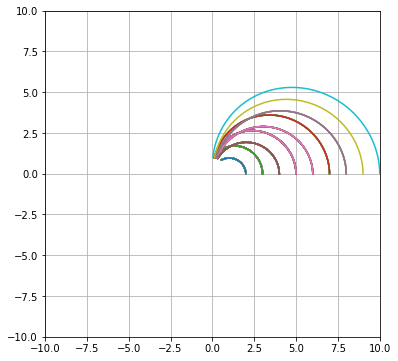

In [11]:
# print(Xi[0, 8, 0, 4, 6, 0])
def indexToSpiral(indexlist):
    wwin = wdis[indexlist[0]]
    xwin = xdis[indexlist[1]]
    ywin = ydis[indexlist[2]]
#     print(xwin, ywin)
    rwin = np.sqrt(xwin**2 + ywin**2)
    xdotwin = xdotdis[indexlist[3]]
    ydotwin = ydotdis[indexlist[4]]
#     print("xdotwin: ", xdotwin)
#     print("ydotwin: ", ydotwin)
    bwin = bdis[indexlist[5]]
    cwin = cdis[indexlist[6]]
    return wwin, rwin, bwin, cwin


# print(checkFeasibility(spirala, fmaxa, deltava))
def plotWinners(wintrajs):
    rfa = 1
    theta0 = 0
    dta = 0.01
    fig = plt.figure(figsize=[6,6])
    for traj in wintrajs:
        wwin, rwin, bwin, cwin = indexToSpiral(traj)
        spiral = ArchimedesSpiral(rwin, rfa, wwin, theta0, bwin, cwin, dta)
        plt.plot(spiral.x,spiral.y)
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.grid()
    plt.show()

def getRefTrajectories(wintrajs):
    reftrajs = []
    rfa = 1
    theta0 = 0
    dta = 0.01
    fig = plt.figure(figsize=[6,6])
    for i in range(len(wintrajs)):
        wwin, rwin, bwin, cwin = indexToSpiral(wintrajs[i])
        spiral = ArchimedesSpiral(rwin, rfa, wwin, theta0, bwin, cwin, dta)
        reftrajs.append(spiral.reftraj)
    return reftrajs

plotWinners(trajs)

Plot with plotly instead

In [12]:
reftrajlisttot = getRefTrajectories(trajs)
maxlen = max([len(traj) for traj in reftrajlisttot])
ti = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, -5, -2, -1]
reftrajlist = [reftrajlisttot[i].tolist() for i in ti]
# print(reftrajlist[0][0])
# reftrajlist = [reftrajlisttot[0], reftrajlisttot[10], reftrajlisttot[20], reftrajlisttot[30], reftrajlisttot[40], reftrajlisttot[50], reftrajlisttot[60], reftrajlisttot[70], reftrajlisttot[80], reftrajlisttot[90], reftrajlisttot[100], reftrajlisttot[110], reftrajlisttot[120],  reftrajlisttot[130], reftrajlisttot[-5], reftrajlisttot[-2], reftrajlisttot[-1]]
for traj in reftrajlist:
    while len(traj) < maxlen:
        traj.append(traj[-1])
# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": [],
    "transition": {}
}
maxlen = max([len(traj) for traj in reftrajlisttot])
print(maxlen)
# fill in most of layout
fig_dict["layout"]["xaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["yaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 0.01, "redraw": False},"transition": {"duration": 0.01}}])])]

# make data
for reftraj in reftrajlist:
    data_dict = {
        "x": [reftraj[0][0]],
        "y": [reftraj[0][1]],
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "size": 9
        }
    }
    fig_dict["data"].append(data_dict)
    
# make frames
animi = np.arange(0,maxlen, 10)
print(animi)
for i in animi:
    frame = {"data": []}
    for reftraj in reftrajlist:
        data_dict = {
            "x": [reftraj[i][0]],
            "y": [reftraj[i][1]],
            "mode": "markers",
            "marker": {
                "sizemode": "area",
                "size": 9
            }
        }
        frame["data"].append(data_dict)
        
    fig_dict["frames"].append(frame)

fig = go.Figure(fig_dict)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 10
fig.update_layout(showlegend=False)
fig.update_layout(
    width = 900,
    height = 900
)
fig.show()

1547
[   0   10   20   30   40   50   60   70   80   90  100  110  120  130
  140  150  160  170  180  190  200  210  220  230  240  250  260  270
  280  290  300  310  320  330  340  350  360  370  380  390  400  410
  420  430  440  450  460  470  480  490  500  510  520  530  540  550
  560  570  580  590  600  610  620  630  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110
 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250
 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390
 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530
 1540]


<Figure size 432x432 with 0 Axes>

In [13]:
reftrajlisttot = getRefTrajectories(trajs)
maxlen = max([len(traj) for traj in reftrajlisttot])
ti = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, -5, -2, -1]
reftrajlist = [reftrajlisttot[i].tolist() for i in ti]
# print(reftrajlist[0][0])
# reftrajlist = [reftrajlisttot[0], reftrajlisttot[10], reftrajlisttot[20], reftrajlisttot[30], reftrajlisttot[40], reftrajlisttot[50], reftrajlisttot[60], reftrajlisttot[70], reftrajlisttot[80], reftrajlisttot[90], reftrajlisttot[100], reftrajlisttot[110], reftrajlisttot[120],  reftrajlisttot[130], reftrajlisttot[-5], reftrajlisttot[-2], reftrajlisttot[-1]]
for traj in reftrajlist:
    while len(traj) < maxlen:
        traj.append(traj[-1])
# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": [],
    "transition": {}
}
maxlen = max([len(traj) for traj in reftrajlisttot])
print(maxlen)
# fill in most of layout
fig_dict["layout"]["xaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["yaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 0.01, "redraw": False},"transition": {"duration": 0.01}}])])]

# make data
for reftraj in reftrajlist:
    data_dict = {
        "x": [reftraj[0][0]],
        "y": [reftraj[0][1]],
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "size": 9
        }
    }
    fig_dict["data"].append(data_dict)
    
# make frames
animi = np.arange(0,maxlen, 10)
print(animi)
for i in animi:
    frame = {"data": []}
    for reftraj in reftrajlist:
        data_dict = {
            "x": [reftraj[i][0]],
            "y": [reftraj[i][1]],
            "mode": "markers",
            "marker": {
                "sizemode": "area",
                "size": 9
            }
        }
        frame["data"].append(data_dict)
        
    fig_dict["frames"].append(frame)

fig = go.Figure(fig_dict)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 10
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 10
fig.update_layout(showlegend=False)
fig.update_layout(
    width = 900,
    height = 900
)
fig.show()

1547
[   0   10   20   30   40   50   60   70   80   90  100  110  120  130
  140  150  160  170  180  190  200  210  220  230  240  250  260  270
  280  290  300  310  320  330  340  350  360  370  380  390  400  410
  420  430  440  450  460  470  480  490  500  510  520  530  540  550
  560  570  580  590  600  610  620  630  640  650  660  670  680  690
  700  710  720  730  740  750  760  770  780  790  800  810  820  830
  840  850  860  870  880  890  900  910  920  930  940  950  960  970
  980  990 1000 1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 1110
 1120 1130 1140 1150 1160 1170 1180 1190 1200 1210 1220 1230 1240 1250
 1260 1270 1280 1290 1300 1310 1320 1330 1340 1350 1360 1370 1380 1390
 1400 1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 1510 1520 1530
 1540]


<Figure size 432x432 with 0 Axes>

Show that we can rotate a spiral to start at any x,y

In [15]:
reftrajlist = [reftrajlisttot[-1].tolist()]
def rotateZ(theta, reftraj):
#     print(theta)
    ct = np.cos(theta)
    st = np.sin(theta)
    R = np.array([
        [ct, st, 0, 0, 0, 0],
        [-st, ct, 0, 0, 0, 0],
        [0, 0, ct, st, 0, 0],
        [0, 0, -st, ct, 0, 0],
        [0, 0, 0, 0, ct, st],
        [0, 0, 0, 0, -st, ct],
    ]) # rotation matrix
    return np.transpose(np.dot(R, np.transpose(reftrajlisttot[-1])))
print(reftrajlisttot[-1].shape)
rotatedtraj = rotateZ(2*math.pi/3.0, reftrajlisttot[-1])
# np.transpose(np.dot(R, np.transpose(reftrajlisttot[-1])))
print(rotatedtraj.shape)
# rottrajlist = [rotatedtraj.tolist()]
rottrajlist = [rotateZ(i, reftrajlisttot[-1]).tolist() for i in np.linspace(0, -2*math.pi/3.0, 20)]
print("rotated traj")
# print("len: ", len(rottraj))

# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": [],
    "transition": {}
}
maxlen = len(reftrajlist[0])
print(maxlen)
# fill in most of layout
fig_dict["layout"]["xaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["yaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 1, "redraw": False},"transition": {"duration": 1}}])])]

# make data
for reftraj in reftrajlist:
    data_dict = {
        "x": [reftraj[i][0] for i in range(len(reftraj))],
        "y": [reftraj[i][1] for i in range(len(reftraj))],
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "size": 3
        }
    }
    fig_dict["data"].append(data_dict)
    
# make frames

for traj in rottrajlist:
    frame = {"data": []}
    data_dict = {
        "x": [traj[i][0] for i in range(len(traj))],
        "y": [traj[i][1] for i in range(len(traj))],
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "size": 3
        }
    }
    frame["data"].append(data_dict)
        
    fig_dict["frames"].append(frame)

fig = go.Figure(fig_dict)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 100
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1
fig.update_layout(showlegend=False)
fig.update_layout(
    width = 900,
    height = 900
)
fig.show()

(1547, 6)
(1547, 6)
rotated traj
1547


Plot the feasibility space

In [160]:
plot_url = py.plot(fig, filename='feasibility_map', include_mathjax='cdn')

def makeSlice(xindex, Xi):
#     print(xdis[xindex])
    xlist = [xdis[xindex] for i in range(Nxd*Nyd)]
    xdotlist = []
    xdoti = []
    ydotlist = []
    ydoti = []
    for i in range(Nyd):
        for xi in range(Nxd):
            xdotlist.append(xdotdis[xi])
            xdoti.append(xi)
    for yi in range(Nyd):
        for i in range(Nxd):
            ydotlist.append(ydotdis[yi])
            ydoti.append(yi)
    colors = []
    for i in range(len(xlist)):
#         print(xindex, xdoti[i], ydoti[i])
        if Xi[0, xindex, 0, xdoti[i], ydoti[i], 0] == 255:
            colors.append(f'rgb(0,0,0)')
        else:
            colors.append(f'rgb(0,255,0)')
#         print(colors)
    return xlist, xdotlist, ydotlist, colors

# make figure
fig_dict = {
    "data": [],
    "layout": {},
    "frames": [],
    "transition": {}
}

# fill in most of layout
fig_dict["layout"]["xaxis"] = {"range": [-15, 15]}
fig_dict["layout"]["yaxis"] = {"range": [-3, 3]}
# fig_dict["layout"]["zaxis"] = {"range": [-3, 3]}
fig_dict["layout"]["hovermode"] = "closest"
fig_dict["layout"]["updatemenus"] = [dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 0.01, "redraw": True},"transition": {"duration":0.01}}])])]

# make data
xf0, yf0, zf0, colors0  = makeSlice(0, Xid)
# for i in range(Nx):
data_dict = {
    "type": 'scatter3d',
    "x": xf0,
    "y": yf0,
    "z": zf0,
    "mode": "markers",
    "marker": {
        "sizemode": "area",
        "size": 7,
        "color": colors0
    }
}
fig_dict["data"].append(data_dict)
    
# make frames
for xi in range(Nx):
    frame = {"data": []}
    slicex, slicey, slicez, slicecolors = makeSlice(xi, Xid)
    data_dict = {
        "type": 'scatter3d',
        "x": slicex,
        "y": slicey,
        "z": slicez,
        "mode": "markers",
        "marker": {
            "sizemode": "area",
            "size": 7,
            "color": slicecolors
        }
    }
    frame["data"].append(data_dict)
        
    fig_dict["frames"].append(frame)
#     print(frame)

fig = go.Figure(fig_dict)
fig.layout.updatemenus[0].buttons[0].args[1]['transition']['duration'] = 1000
fig.layout.updatemenus[0].buttons[0].args[1]['frame']['duration'] = 1000
fig.update_layout(showlegend=False)
fig.update_layout(
    width = 900,
    scene = dict( xaxis = dict(nticks = 10, range=[0, 10]), 
    yaxis = dict(range=[-3,3]),
    zaxis = dict(range=[-3,3]), 
    aspectratio=dict(x=1,y=1,z=1),
                xaxis_title="X (m)", yaxis_title="X Velocity (m/s)", zaxis_title="Y Velocity (m/s)")
)
fig.update_layout(title={'text':"Discretized Feasibility Space",'xanchor':'center','yanchor':'top','y':0.9,'x':0.48})

fig.show()
print(Xid[0, :, 0, :,:,0])

[[[255 255 255 255 255 255 255 255 255]
  [255 255 255   0   0   0   0 255 255]
  [255 255   0   0   0   0   0   0 255]
  [255   0   0   0   0   0   0   0 255]
  [255   0   0   0   0   0   0   0 255]
  [255   0   0   0   0   0   0   0 255]
  [255 255   0   0   0   0   0   0 255]
  [255 255 255   0   0   0   0 255 255]
  [255 255 255 255 255 255 255 255 255]]

 [[255 255 255 255 255 255 255 255 255]
  [255 255 255 255   0   0 255 255 255]
  [255 255 255   0   0   0   0   0 255]
  [255 255   0   0   0   0   0   0 255]
  [255 255   0   0   0   0   0   0 255]
  [255 255   0   0   0   0   0   0 255]
  [255 255 255   0   0   0   0   0 255]
  [255 255 255 255   0   0 255 255 255]
  [255 255 255 255 255 255 255 255 255]]

 [[255 255 255 255 255 255 255 255 255]
  [255 255 255 255 255 255 255 255 255]
  [255 255 255   1   1   1   1 255 255]
  [255 255 255   1   1   1   1   1 255]
  [255 255 255   1   1   1   1   1 255]
  [255 255 255   1   1   1   1   1 255]
  [255 255 255   1   1   1   1 255 2

In [78]:
# Helix equation
t = np.linspace(0, 20, 100)
x, y, z = np.cos(t), np.sin(t), t

fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
print(fig.data)
fig.show()

(Scatter3d({
    'marker': {'color': array([ 0.        ,  0.2020202 ,  0.4040404 ,  0.60606061,  0.80808081,
                                1.01010101,  1.21212121,  1.41414141,  1.61616162,  1.81818182,
                                2.02020202,  2.22222222,  2.42424242,  2.62626263,  2.82828283,
                                3.03030303,  3.23232323,  3.43434343,  3.63636364,  3.83838384,
                                4.04040404,  4.24242424,  4.44444444,  4.64646465,  4.84848485,
                                5.05050505,  5.25252525,  5.45454545,  5.65656566,  5.85858586,
                                6.06060606,  6.26262626,  6.46464646,  6.66666667,  6.86868687,
                                7.07070707,  7.27272727,  7.47474747,  7.67676768,  7.87878788,
                                8.08080808,  8.28282828,  8.48484848,  8.68686869,  8.88888889,
                                9.09090909,  9.29292929,  9.49494949,  9.6969697 ,  9.8989899 ,
                           

# Trajectory Selection

x
[[10.]
 [ 0.]
 [-0.]
 [ 1.]]
nearest state
[[10.]
 [ 0.]
 [ 0.]
 [ 1.]]
[[10.]
 [ 0.]
 [ 0.]
 [ 1.]]


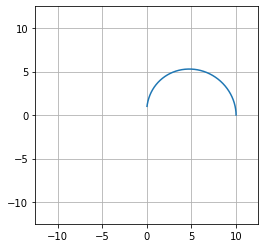

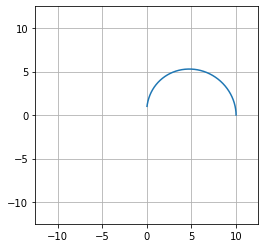

feasibility of nearest spiral
(True, True, 1.8340454902556136)
velocity of nearest spiral at t=0
[-0.00296311  0.99999648]
velocity of nearest xi
[0. 1.]
velocity of the recommended spiral at t=0
[-0.00296311  0.99999648]
velocity of the rotxi
[0. 1.]
deltav between nearestxispiral and nearestxi
0.002963110369516626
deltav between spiral velocity at t=0 and rotxi
0.002963110369516626
cost of the nearestspiral and nearestxi
-0.16299139937486973
cost of the spiral and rotxi
-0.16299139937486973
(0.1, 10.0, 4.0, 0.5377777777777777, 0.0)


In [179]:
def findSpiral(x, omega, Xi):
    ##### INPUTS:
    # x: a (6,1) numpy array, continuous state for which we need to find a spiral reference traj
    # omega: a float, the docking port angular vel in rad/s
    # assumes the satellite has the same fmax and deltav for the satellite mapped in the feasibility space
    
    ##### OUTPUTS:
    # r0, omega, b, c: floats, params that complete the spiral
    # theta: the angle to rotate the scene (or spiral) so the reftraj applies to the current x
    # OR None for all values if the recommendation is to abort
    
    # first downselect to the nearest omega
    
    wi = np.argmin((wdis - omega)**2) # omega index
    w = wdis[wi] # omega discretized
    
    # next downselect to the nearest x
    # calculate the current radius from x
    r0c = np.sqrt(x[0,0]**2 + x[1,0]**2) # continuous radius
    # calculate the radius of the spiral
    xi = np.argmin((xdis - r0c)**2) # index of nearest discretized x
    yi = 0 # index of nearest discretized y
    xdoti = np.argmin((xdotdis - x[2,0])**2) # index of nearest discretized xdot
    ydoti = np.argmin((ydotdis - x[3,0])**2) # index of nearest discretized ydot
    bi = Xi[wi, xi, yi, xdoti, ydoti, 0] # index of nearest discretized b
    ci = Xi[wi, xi, yi, xdoti, ydoti, 1] # index of nearest discretized c
    nearestx = np.array([
        [xdis[xi]],
        [ydis[yi]],
        [xdotdis[xdoti]],
        [ydotdis[ydoti]]
    ])
    nearestxi = np.array([
        [w],
        [xdis[xi]],
        [ydis[yi]],
        [xdotdis[xdoti]],
        [ydotdis[ydoti]]
    ])
    print("x")
    print(x)
    print("nearest state")
    print(nearestx)
    
    if bi == 255:
        return None, None, None, None, None
    else:
        b = bdis[bi]
        c = cdis[ci]
        # rotate the state x so it falls on the +x axis
        theta = np.arctan2(x[1,0], x[0,0])
        ct = np.cos(theta)
        st = np.sin(theta)
        R0T = np.array([
            [ct, st, 0, 0],
            [-st, ct, 0, 0],
            [0, 0, ct, st],
            [0, 0, -st, ct]
        ]) # rotation matrix
        rotx = np.dot(R0T, x) # rotated state
        rotxi = np.array([
            [omega],
            [rotx[0,0]],
            [rotx[1,0]],
            [rotx[2,0]],
            [rotx[3,0]]
        ])
#         print("rotated x")
        print(rotx)
        spiral = ArchimedesSpiral(r0c, rf, omega, 0, b, c, dt)
        nearestspiral = ArchimedesSpiral(xdis[xi], rf, omega, 0, b, c, dt)
#         print("Nearest spiral: ", w, xdis[xi], b, c)
        nearestspiral.showSpiral()
        spiral.showSpiral()
        print("feasibility of nearest spiral")
        print(checkFeasibility(nearestspiral, fmax, deltavmax))
        print("velocity of nearest spiral at t=0")
        print(nearestspiral.reftraj[1,2:4])
        print("velocity of nearest xi")
        print(nearestxi[3:,0])
        print("velocity of the recommended spiral at t=0")
        print(spiral.reftraj[1,2:4])
        print("velocity of the rotxi")
        print(rotxi[3:,0])
        print("deltav between nearestxispiral and nearestxi")
        print(np.linalg.norm(nearestspiral.reftraj[1,2:4] - nearestxi[3:,0]))
        print("deltav between spiral velocity at t=0 and rotxi")
        print(np.linalg.norm(spiral.reftraj[1,2:4] - rotxi[3:,0]))
        print("cost of the nearestspiral and nearestxi")
        print(calculateCost(nearestspiral, fmax, deltavmax, nearestxi))
        print("cost of the spiral and rotxi")
        print(calculateCost(spiral, fmax, deltavmax, rotxi))
        if calculateCost(spiral, fmax, deltavmax, rotxi) < 0:
            return omega, r0c, b, c, theta
        else:
            return None, None, None, None, None

##### Test #####
testx = np.array([
    [10],
    [0],
    [-0.0],
    [1]
])
print(findSpiral(testx, 0.1, Xid))
    

In [86]:
class Controller():
    def __init__(self, A, B, Q, R, Qf, umin, umax, dt=0.01):
        ##### INPUTS: 
        # A: a numpy array of shape (n,n) representing the A matrix in discrete LTI state space form
        # B: a numpy array of shape (n,m) representing the B matrix in discrete LTI state space form
        # Q: 
        # R: 
        # Qf: 
        # umin: a numpy array of shape (n, 1) describing the min thrust the chaser is capable of (described in the frame of the chaser)
        # umax: a numpy array of shape (n, 1) describing the max thrust the chaser is capable of (described in the frame of the chaser)
        # dt: 
        self.A = A
        self.B = B
        self.n = A.shape[0] # dimensionality
        self.m = B.shape[1] # number of control inputs
        self.Q = Q
        self.R = R
        self.Qf = Qf
        self.umin = umin
        self.umax = umax
        self.dt = dt
        
        
        
        ##### Run LQR to find P and K
#         self.F = np.array([
#             [1, 0, self.dt, 0, 0, 0],
#             [0, 1, 0, self.dt, 0, 0],
#             [0, 0, 1, 0, self.dt, 0],
#             [0, 0, 0, 1, 0, self.dt],
#             [0, 0, 0, 0, 1, 0],
#             [0, 0, 0, 0, 0, 1]
#         ])
        
#         self.A1 = 
#         
        print("Instantiating controller gains")
        
        ##### SCIPY DARE #####
#         Pss = la.solve_discrete_are(self.A, self.B, self.Q, self.R)
#         inv = np.linalg.inv(self.R + np.dot(np.transpose(B), np.dot(Pss, B)))
#         self.K = -np.dot(inv, np.dot(np.transpose(B), np.dot(Pss, A)))
#         self.Kv = np.dot(inv, np.transpose(B))
#         print("Kv shape: ", self.Kv.shape)
        
        ##### CUSTOM DARE #####
        P_now = Qf
        K_now = np.zeros((self.m,self.n))
        P_prev = np.zeros((self.n,self.n))
        K_prev = np.zeros((self.m,self.n))
        while not np.allclose(P_now,P_prev):
            P_now = np.copy(P_prev)
            K_now = np.copy(K_prev)
            P_prev = self.Q + np.dot(np.transpose(K_now),np.dot(self.R,K_now)) + np.transpose(self.A - np.dot(self.B, K_now))*P_now*(self.A - np.dot(self.B, K_now))
            K_prev = np.dot(np.linalg.inv(self.R + np.dot(np.transpose(self.B), np.dot(P_now, self.B))), np.dot(np.transpose(self.B), np.dot(P_now, self.A)))
        self.K = -K_prev
        self.P = P_prev
        print("Instantiated controller gains")
        
    def lqrTracker(self, xhat, ref, ref2):
        ##### INPUTS: 
        # xhat: a numpy array of shape (n, 1) representing the current state estimate (mean)
        # target: a numpy array of shape (n+m,1) describing the x,y,xdot,ydot target to hit for the next timestep
        # for the rendezvous, target should be in sync rotation with the docking port
        
        ##### OUTPUTS:         
        # utframe: a numpy array of shape (2,1) representing the control inputs that are optimal for this timestep (in the frame of the target)
        # ucframe: a numpy array of shape (2,1) representing the control inputs that are optimal for this timestep (in the frame of the chaser)
        
        # initialize the array of difference vectors xport-xpredictions to use for control
        n = xhat.shape[0]
        target = ref[0:n,:]
        print("reftraj: \n", ref)
        xdiff = xhat - target
#         xdiff = xhat 
        
        # calculate the rotation frames between the target and chaser
        theta = np.arctan2(xhat[1,0], xhat[0,0])
        RTC = np.array([
            [-np.sin(theta), -np.cos(theta)],
            [np.cos(theta), -np.sin(theta)]
        ])
        RCT = np.transpose(RTC)
        
        # calculate the umax and umin in the target's frame
        umaxvec = np.dot(RTC, self.umax)
        uminvec = np.dot(RTC, self.umin)
        
        # calculate u 
#         utframe = np.clip(np.dot(-self.K, xdiff), np.squeeze(umaxvec), np.squeeze(uminvec)) # apply u limits in the rotated frame
        nexttarget = ref2[0:n,:]
        ud = np.linalg.pinv(self.B).dot(nexttarget - self.A.dot(target))
        
        utframe = np.dot(self.K, xdiff) + ud # WITH UD
#         utframe = np.dot(self.K, xdiff) # NO UD
        ucframe = np.dot(RCT, utframe)
    
        # print statements for debugging
        print("x: \n", xhat)
        print("target: \n", target)
        print("xdiff: \n", xdiff)
        print("utframe: \n", utframe)
        print("utframe shape: ", utframe.shape)
        print("K shape: ", self.K.shape)
        print("K: \n", self.K)
        print("xdifff shape: ", xdiff.shape)
        print("ud:\n", ud)
        print("ud shape: ", ud.shape)
        print("\n")
        
        return utframe, ucframe
        

    def mpc(self, xhat, reftraj):
        # take in the reftraj, assuming len(reftraj) = Np, the prediction horizon
        
        # linearize the reftraj to construct F
        
        # construct the new A and B
        
        # calculate the P for this horizon
        
        # calculate the gain K for this horizon
        
        # calculate the gains u in the frame of the target and chaser over the horizon
        
        Pss = la.solve_discrete_are(self.A, self.B, self.Q, self.R)
        inv = np.linalg.inv(self.R + np.dot(np.transpose(B), np.dot(Pss, B)))
        self.K = -np.dot(inv, np.dot(np.transpose(B), np.dot(Pss, A)))
        
        
        return utframe, ucframe
        
        
   



In [87]:
##### alternate approach: Run LQR online to find P and K
# for a description of the algorithm, see pg 23 of https://stanford.edu/class/ee363/lectures/dlqr.pdf

# initialize array of Pn for the LQR
# Pn = np.zeros(Np, m, m)
# Pn[Np-1,:,:] = Qf
# iterate backwards from N,...,1 and populate P by the equation for P_{t-1}

# iterate forwards from 0,...,N-1 and define K_t
# self.Ks = np.zeros(Np, m, m)

In [98]:
maxforce = 1
base = Base(deltaT = 0.01, fmax = maxforce)
Q = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])
R = 100*np.eye(2)
Qf = Q
maxbounds = 10
maxvel = 1
omegamax=10
umin = -maxforce * np.ones((2,1))
# print(umin)
umax = maxforce * np.ones((2,1))
ctrl = Controller(base.Ad, base.Bd, Q, R, Qf, umin, umax)

0.12154255465717591 398860000000000.0 300000
Instantiating controller gains
Instantiated controller gains


In [99]:
print(np.dot(np.linalg.pinv(ctrl.B), ctrl.B))
print(np.linalg.pinv(ctrl.B) @ ctrl.B)
print(np.linalg.pinv(ctrl.B).dot(ctrl.B))

[[1.00000000e+00 2.16840434e-19]
 [1.08420217e-19 1.00000000e+00]]
[[1.00000000e+00 2.16840434e-19]
 [1.08420217e-19 1.00000000e+00]]
[[1.00000000e+00 2.16840434e-19]
 [1.08420217e-19 1.00000000e+00]]


In [100]:
class Simulator():
    def __init__(self, base, ctrl, umin, umax, maxradius = 10, maxvel = 1, omegamax=1.0):
        self.dt = base.deltaT
        self.base = base
        self.ctrl = ctrl
        self.maxradius = maxradius
        self.portradius = 1
        
        self.omegamax = omegamax # rad/s
        self.omegamin = -self.omegamax
        
        
    def step(self, x, target, nexttarget):
        ##### INPUTS
        # x: the true state
        # xhat: the state estimate
        
        # propagate the true state and calculate the next state
        Np = 10
        Nc = 1
        
        # calculate u
        utframe, ucframe = self.ctrl.lqrTracker(x, target, nexttarget)
    
        # step the sim
        xnext = np.dot(self.base.Ad, x) + np.dot(self.base.Bd, utframe)  
        
        # return the next real state and the next docking port x and y
        return xnext
    
    def monteCarloRun(self):
        # initialize the variables that define the starting point
#         omega = np.random.uniform(self.omegamin, self.omegamax)
#         theta = np.random.uniform(0, 2*math.pi)        
#         xradius = np.random.uniform(0, self.maxradius)
        
        ##### hardcoded values
        omega = 0.1 
        theta = 0 
        xradius = 10
        c = 1
        b = 7
        spiral = ArchimedesSpiral(xradius, self.portradius, omega, theta, b, c, self.dt)
        Xport = np.zeros((spiral.H, 4))
        Xport[:,0] = spiral.xport
        Xport[:,1] = spiral.yport
        Xport[:,2] = spiral.xdotport
        Xport[:,3] = spiral.ydotport
        print("steps: ", spiral.H)
        #####
        
        rport = self.portradius * np.array([[np.cos(theta)],[np.sin(theta)]])
        Xtrue_i = np.zeros((4,1)) 
        Xtrue_i[0,0] = xradius * np.cos(theta)
        Xtrue_i[1,0] = xradius * np.sin(theta)
        Xtrue_i[2,0] = -xradius * np.sin(theta)*omega
        Xtrue_i[3,0] = xradius * np.cos(theta)*omega
        Xtrue = [Xtrue_i]
        
        
        print("omega: ", omega)
        print("theta: ", theta)
        print("port: ", rport)
        print("radius: ", xradius)
        print("Xtrue_i")
        print(Xtrue_i)
        
        for i in range(spiral.H-2):
            xtruenext = self.step(Xtrue[-1],np.reshape(spiral.reftraj[i+1,:], (6,1)), np.reshape(spiral.reftraj[i+2,:], (6,1)))
            Xtrue.append(np.copy(xtruenext))
        xtruenext = self.step(Xtrue[-1],np.reshape(spiral.reftraj[-1,:], (6,1)), np.zeros((6,1)))
        Xtrue.append(np.copy(xtruenext))
        return Xtrue, Xport
            
    def goalReached(self, rport, omega, x):
        # check that x matches the current docking port and angular velocity with some bounds
        theta0 = np.arctan2(rport[1,0], rport[0,0])
        xportnow = np.zeros((4,1))
        xportnow[0,0] = np.cos(theta0)
        xportnow[1,0] = np.sin(theta0)
        xportnow[2,0] = -np.sin(theta0) * omega
        xportnow[3,0] = np.cos(theta0) * omega
        
        # return a boolean checking whether or not xportnow and x are close
        return np.allclose(xportnow, x, atol=1e-03)     

In [101]:
sim = Simulator(base, ctrl, umin, umax)
Xchaser, Xport = sim.monteCarloRun()

shape:  (1286,)
steps:  1286
omega:  0.1
theta:  0
port:  [[1.]
 [0.]]
radius:  10
Xtrue_i
[[10.]
 [ 0.]
 [-0.]
 [ 1.]]
reftraj: 
 [[ 9.992995  ]
 [ 0.009993  ]
 [-0.70099895]
 [ 0.9985995 ]
 [-0.09978995]
 [-0.14009986]]
x: 
 [[10.]
 [ 0.]
 [-0.]
 [ 1.]]
target: 
 [[ 9.992995  ]
 [ 0.009993  ]
 [-0.70099895]
 [ 0.9985995 ]]
xdiff: 
 [[10.]
 [ 0.]
 [-0.]
 [ 1.]]
utframe: 
 [[-1.16866328]
 [-0.10110036]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.05289194]
 [-0.01053998]]
ud shape:  (2, 1)


reftraj: 
 [[ 9.98598003]
 [ 0.01997199]
 [-0.7019958 ]
 [ 0.997198  ]
 [-0.0995798 ]
 [-0.14019944]]
x: 
 [[ 9.99997588e+00]
 [ 9.99496453e-03]
 [-8.93000603e-02]
 [ 9.69918831e-01]]
target: 
 [[ 9.98598003]
 [ 0.01997199]
 [-0.7019958 ]
 [ 0.997198  ]]
xdiff: 
 [[ 9.99997588e+00]
 [ 9.99496453e-03]
 [-8.93000603e-02]
 [ 9.69918831e

 [-0.10311817]]
utframe: 
 [[-0.01406539]
 [-0.007674  ]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.03786203]
 [-0.01146545]]
ud shape:  (2, 1)


reftraj: 
 [[ 9.30075743]
 [ 0.87685535]
 [-0.78459521]
 [ 0.8643726 ]
 [-0.07986695]
 [-0.14815049]]
x: 
 [[ 0.14617844]
 [ 0.23239776]
 [-0.00413957]
 [-0.1054042 ]]
target: 
 [[ 9.30075743]
 [ 0.87685535]
 [-0.78459521]
 [ 0.8643726 ]]
xdiff: 
 [[ 0.14617844]
 [ 0.23239776]
 [-0.00413957]
 [-0.1054042 ]]
utframe: 
 [[-0.00881161]
 [-0.00735863]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.037701  ]
 [-0.01147425]]
ud shape:  (2, 1)


reftraj: 
 [[ 9.29290748]
 [ 0.88549167]
 [-0.78539279]
 [ 0.86289073]
 [-0

 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.02133195]
 [-0.01223829]]
ud shape:  (2, 1)


reftraj: 
 [[ 8.43713876]
 [ 1.70151064]
 [-0.85633639]
 [ 0.70533146]
 [-0.0566949 ]
 [-0.15425217]]
x: 
 [[-2.56375718e-02]
 [ 9.82507751e-02]
 [ 9.19368316e-05]
 [-1.02837639e-01]]
target: 
 [[ 8.43713876]
 [ 1.70151064]
 [-0.85633639]
 [ 0.70533146]]
xdiff: 
 [[-2.56375718e-02]
 [ 9.82507751e-02]
 [ 9.19368316e-05]
 [-1.02837639e-01]]
utframe: 
 [[0.00309723]
 [0.00268538]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.0211787 ]
 [-0.01224417]]
ud shape:  (2, 1)


reftraj: 
 [[ 8.42857257]
 [ 1.70855624]
 [-0.85690223]
 [ 0.70378873]
 [-0.05647202]
 [-0.15429488]]
x: 
 [[-2.48823073e-02]
 [ 9.72225328e-02]
 [ 8.56869603e-05]
 [-1.02034776e-01]]
target: 
 [[ 8.42857257]
 [ 1.7


reftraj: 
 [[ 7.50200628]
 [ 2.36180582]
 [-0.90387345]
 [ 0.53999541]
 [-0.03297902]
 [-0.15715663]]
x: 
 [[-8.80705171e-03]
 [ 2.84790582e-02]
 [ 1.19935478e-05]
 [-3.57257304e-02]]
target: 
 [[ 7.50200628]
 [ 2.36180582]
 [-0.90387345]
 [ 0.53999541]]
xdiff: 
 [[-8.80705171e-03]
 [ 2.84790582e-02]
 [ 1.19935478e-05]
 [-3.57257304e-02]]
utframe: 
 [[0.00110226]
 [0.00136637]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.00548863]
 [-0.01270972]]
ud shape:  (2, 1)


reftraj: 
 [[ 7.4929659 ]
 [ 2.36719792]
 [-0.90420212]
 [ 0.53842378]
 [-0.0327551 ]
 [-0.15716844]]
x: 
 [[-8.70877258e-03]
 [ 2.81218694e-02]
 [ 1.20724910e-05]
 [-3.53171183e-02]]
target: 
 [[ 7.4929659 ]
 [ 2.36719792]
 [-0.90420212]
 [ 0.53842378]]
xdiff: 
 [[-8.70877258e-03]
 [ 2.81218694e-02]
 [ 1.20724910e-05]
 [-3.53171183e-02]]
utframe: 
 [[0.0010

 [-3.07151373e-02]]
utframe: 
 [[0.00094412]
 [0.00120092]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.00364791]
 [-0.01274519]]
ud shape:  (2, 1)


reftraj: 
 [[ 7.37515104]
 [ 2.43586454]
 [-0.90827111]
 [ 0.51798309]
 [-0.02984511]
 [-0.15729558]]
x: 
 [[-7.46031978e-03]
 [ 2.38360473e-02]
 [ 1.04908934e-05]
 [-3.03560007e-02]]
target: 
 [[ 7.37515104]
 [ 2.43586454]
 [-0.90827111]
 [ 0.51798309]]
xdiff: 
 [[-7.46031978e-03]
 [ 2.38360473e-02]
 [ 1.04908934e-05]
 [-3.03560007e-02]]
utframe: 
 [[0.00093331]
 [0.00118878]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[-0.00350714]
 [-0.01274773]]
ud shape:  (2, 1)


reftraj: 
 [[ 7.36606684]
 [ 2.44103651]
 [

 [ 0.37644889]]
xdiff: 
 [[-2.43199899e-03]
 [ 7.16978172e-03]
 [ 3.86018647e-06]
 [-9.85895592e-03]]
utframe: 
 [[0.00030327]
 [0.00042992]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.00864549]
 [-0.01286191]]
ud shape:  (2, 1)


reftraj: 
 [[ 6.53907147]
 [ 2.84208451]
 [-0.92619303]
 [ 0.37488062]
 [-0.00958541]
 [-0.15681776]]
x: 
 [[-2.40034910e-03]
 [ 7.07121370e-03]
 [ 3.81152252e-06]
 [-9.73038823e-03]]
target: 
 [[ 6.53907147]
 [ 2.84208451]
 [-0.92619303]
 [ 0.37488062]]
xdiff: 
 [[-2.40034910e-03]
 [ 7.07121370e-03]
 [ 3.81152252e-06]
 [-9.73038823e-03]]
utframe: 
 [[0.00029932]
 [0.0004247 ]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0087744

 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.02047229]
 [-0.01273619]]
ud shape:  (2, 1)


reftraj: 
 [[ 5.63949716]
 [ 3.13232705]
 [-0.92517628]
 [ 0.22405994]
 [ 0.01158298]
 [-0.15371199]]
x: 
 [[-6.38891920e-04]
 [ 1.76537035e-03]
 [ 1.09385934e-06]
 [-2.58522824e-03]]
target: 
 [[ 5.63949716]
 [ 3.13232705]
 [-0.92517628]
 [ 0.22405994]]
xdiff: 
 [[-6.38891920e-04]
 [ 1.76537035e-03]
 [ 1.09385934e-06]
 [-2.58522824e-03]]
utframe: 
 [[7.94970270e-05]
 [1.21526588e-04]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0205867 ]
 [-0.01273357]]
ud shape:  (2, 1)


reftraj: 
 [[ 5.63024598]
 [ 3.13455996]
 [-0.92505938]
 [ 0.22252305]
 [ 0.01179785]
 [-0.15366628]]
x: 
 [[-6.29920979e-04]
 [ 1.73952415e-03]
 [ 1.07923795e-06]
 [-2.54888510e-03]]
target: 
 [[ 5.63024598

x: 
 [[-5.31207552e-04]
 [ 1.45636068e-03]
 [ 9.17297996e-07]
 [-2.14906996e-03]]
target: 
 [[ 5.51932998]
 [ 3.16015768]
 [-0.92348919]
 [ 0.2041169 ]]
xdiff: 
 [[-5.31207552e-04]
 [ 1.45636068e-03]
 [ 9.17297996e-07]
 [-2.14906996e-03]]
utframe: 
 [[6.60811126e-05]
 [1.01880059e-04]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.02205944]
 [-0.01269714]]
ud shape:  (2, 1)


reftraj: 
 [[ 5.51009581]
 [ 3.16219119]
 [-0.92334443]
 [ 0.20258619]
 [ 0.01458372]
 [-0.15304697]]
x: 
 [[-5.23684412e-04]
 [ 1.43487509e-03]
 [ 9.04867351e-07]
 [-2.11860219e-03]]
target: 
 [[ 5.51009581]
 [ 3.16219119]
 [-0.92334443]
 [ 0.20258619]]
xdiff: 
 [[-5.23684412e-04]
 [ 1.43487509e-03]
 [ 9.04867351e-07]
 [-2.11860219e-03]]
utframe: 
 [[6.51440371e-05]
 [1.00499971e-04]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.

 [-5.82272250e-04]]
target: 
 [[ 4.70560487]
 [ 3.28183666]
 [-0.902338  ]
 [ 0.07012722]]
xdiff: 
 [[-1.44116787e-04]
 [ 3.74824708e-04]
 [ 2.62503792e-07]
 [-5.82272250e-04]]
utframe: 
 [[1.78983688e-05]
 [2.91187408e-05]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0313848 ]
 [-0.01232884]]
ud shape:  (2, 1)


reftraj: 
 [[ 4.69658314]
 [ 3.28253055]
 [-0.90200667]
 [ 0.06865109]
 [ 0.03323561]
 [-0.14757603]]
x: 
 [[-1.41963521e-04]
 [ 3.69003443e-04]
 [ 2.58729985e-07]
 [-5.73564101e-04]]
target: 
 [[ 4.69658314]
 [ 3.28253055]
 [-0.90200667]
 [ 0.06865109]]
xdiff: 
 [[-1.41963521e-04]
 [ 3.69003443e-04]
 [ 2.58729985e-07]
 [-5.73564101e-04]]
utframe: 
 [[1.76306269e-05]
 [2.86997848e-05]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-0

 [-4.78360934e-04]]
utframe: 
 [[1.47035753e-05]
 [2.41017588e-05]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.03263194]
 [-0.01225801]]
ud shape:  (2, 1)


reftraj: 
 [[ 4.57961061]
 [ 3.29021089]
 [-0.89751327]
 [ 0.04952914]
 [ 0.03589028]
 [-0.14660055]]
x: 
 [[-1.16637912e-04]
 [ 3.00810395e-04]
 [ 2.14163851e-07]
 [-4.71153142e-04]]
target: 
 [[ 4.57961061]
 [ 3.29021089]
 [-0.89751327]
 [ 0.04952914]]
xdiff: 
 [[-1.16637912e-04]
 [ 3.00810395e-04]
 [ 2.14163851e-07]
 [-4.71153142e-04]]
utframe: 
 [[1.44819739e-05]
 [2.37522342e-05]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.03272662]
 [-0.01225238]]
ud shape:  (2, 1)


reftraj: 
 [[ 4.57063727]
 

 [-1.23451379e-04]]
utframe: 
 [[3.79333345e-06]
 [6.54380907e-06]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.04018094]
 [-0.01167632]]
ud shape:  (2, 1)


reftraj: 
 [[ 3.81456024]
 [ 3.27872387]
 [-0.8587257 ]
 [-0.07482762]
 [ 0.05311113]
 [-0.1389579 ]]
x: 
 [[-3.01169985e-05]
 [ 7.34067133e-05]
 [ 5.81683095e-08]
 [-1.21494402e-04]]
target: 
 [[ 3.81456024]
 [ 3.27872387]
 [-0.8587257 ]
 [-0.07482762]]
xdiff: 
 [[-3.01169985e-05]
 [ 7.34067133e-05]
 [ 5.81683095e-08]
 [-1.21494402e-04]]
utframe: 
 [[3.73318576e-06]
 [6.44398229e-06]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.04025944]
 [-0.01166856]]
ud shape:  (2, 1)


reftraj: 
 [[ 3.80597564]
 

 [-9.70400478e-05]]
utframe: 
 [[2.98160111e-06]
 [5.19133082e-06]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0413382 ]
 [-0.01155758]]
ud shape:  (2, 1)


reftraj: 
 [[ 3.68635965]
 [ 3.26594206]
 [-0.8505438 ]
 [-0.09555884]
 [ 0.05597537]
 [-0.13744934]]
x: 
 [[-2.36760902e-05]
 [ 5.70822684e-05]
 [ 4.61490226e-08]
 [-9.54875385e-05]]
target: 
 [[ 3.68635965]
 [ 3.26594206]
 [-0.8505438 ]
 [-0.09555884]]
xdiff: 
 [[-2.36760902e-05]
 [ 5.70822684e-05]
 [ 4.61490226e-08]
 [-9.54875385e-05]]
utframe: 
 [[2.93388737e-06]
 [5.11144902e-06]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.04141381]
 [-0.01154948]]
ud shape:  (2, 1)


reftraj: 
 [[ 3.67785702]
 

 [[6.79544904e-07]
 [1.25844598e-06]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.04729573]
 [-0.01074699]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.95373503]
 [ 3.12772335]
 [-0.79338938]
 [-0.21355405]
 [ 0.07224816]
 [-0.12740064]]
x: 
 [[-5.40206959e-06]
 [ 1.20399065e-05]
 [ 1.11917426e-08]
 [-2.17496421e-05]]
target: 
 [[ 2.95373503]
 [ 3.12772335]
 [-0.79338938]
 [-0.21355405]]
xdiff: 
 [[-5.40206959e-06]
 [ 1.20399065e-05]
 [ 1.11917426e-08]
 [-2.17496421e-05]]
utframe: 
 [[6.67982531e-07]
 [1.23800982e-06]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.04735367]
 [-0.01073688]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.94580475]
 [ 3.12558145]
 [-0.79266602]
 

 [-0.23126845]]
xdiff: 
 [[-4.24387244e-06]
 [ 9.31166807e-06]
 [ 8.89106145e-09]
 [-1.70809742e-05]]
utframe: 
 [[5.24554525e-07]
 [9.83290402e-07]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.04814341]
 [-0.01059313]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.83554925]
 [ 3.09426396]
 [-0.78235574]
 [-0.23252436]
 [ 0.07486037]
 [-0.12552851]]
x: 
 [[-4.17091140e-06]
 [ 9.14090754e-06]
 [ 8.74538538e-09]
 [-1.67869117e-05]]
target: 
 [[ 2.83554925]
 [ 3.09426396]
 [-0.78235574]
 [-0.23252436]]
xdiff: 
 [[-4.17091140e-06]
 [ 9.14090754e-06]
 [ 8.74538538e-09]
 [-1.67869117e-05]]
utframe: 
 [[5.15520833e-07]
 [9.67163650e-07]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
u

 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0519966]
 [-0.0096574]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.2135905 ]
 [ 2.85927842]
 [-0.7144437 ]
 [-0.33215171]
 [ 0.08856625]
 [-0.11429596]]
x: 
 [[-9.32512545e-07]
 [ 1.78984705e-06]
 [ 2.12600066e-09]
 [-3.74351117e-06]]
target: 
 [[ 2.2135905 ]
 [ 2.85927842]
 [-0.7144437 ]
 [-0.33215171]]
xdiff: 
 [[-9.32512545e-07]
 [ 1.78984705e-06]
 [ 2.12600066e-09]
 [-3.74351117e-06]]
utframe: 
 [[1.14889012e-07]
 [2.34737596e-07]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.05203428]
 [-0.00964529]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.2064505 ]
 [ 2.85595119]
 [-0.71355725]
 [-0.33329395]
 [ 0.08872329]
 [-0.11415194]]
x: 
 [[-9.15062549e-07]
 [ 1.75242368e-06]
 [ 2.08886081e-09]
 [-3.67331024e-06]]
target: 
 [[ 2.2064505 ]


 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.05253977]
 [-0.00947371]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.10742912]
 [ 2.80817797]
 [-0.7009831 ]
 [-0.34913307]
 [ 0.09090091]
 [-0.11211484]]
x: 
 [[-7.00570422e-07]
 [ 1.29686907e-06]
 [ 1.62935362e-09]
 [-2.81058200e-06]]
target: 
 [[ 2.10742912]
 [ 2.80817797]
 [-0.7009831 ]
 [-0.34913307]]
xdiff: 
 [[-7.00570422e-07]
 [ 1.29686907e-06]
 [ 1.62935362e-09]
 [-2.81058200e-06]]
utframe: 
 [[8.62434625e-08]
 [1.79835693e-07]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.05257429]
 [-0.00946131]]
ud shape:  (2, 1)


reftraj: 
 [[ 2.10042383]
 [ 2.80468104]
 [-0.70007332]
 [-0.35025349]
 [ 0.09105494]
 [-0.11196785]]
x: 
 [[-6.87196203e-07]
 [ 1.26877225e-06]
 [ 1.60049456e-09]
 [-2.75680003e-06]]
target: 
 [[ 2.10042383

 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.05476784]
 [-0.00831318]]
ud shape:  (2, 1)


reftraj: 
 [[ 1.5274597 ]
 [ 2.4592462 ]
 [-0.61525857]
 [-0.44189042]
 [ 0.10365268]
 [-0.09845925]]
x: 
 [[-1.11242701e-07]
 [ 1.26917319e-07]
 [ 3.11872135e-10]
 [-4.43292277e-07]]
target: 
 [[ 1.5274597 ]
 [ 2.4592462 ]
 [-0.61525857]
 [-0.44189042]]
xdiff: 
 [[-1.11242701e-07]
 [ 1.26917319e-07]
 [ 3.11872135e-10]
 [-4.43292277e-07]]
utframe: 
 [[1.35797305e-08]
 [3.43155535e-08]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0547837 ]
 [-0.00829922]]
ud shape:  (2, 1)


reftraj: 
 [[ 1.5213123 ]
 [ 2.45482237]
 [-0.61422137]
 [-0.44287419]
 [ 0.10378796]
 [-0.09829605]]
x: 
 [[-1.08681707e-07]
 [ 1.22486112e-07]
 [ 3.05707628e-10]
 [-4.33029699e-07]]
target: 
 [[ 1.5213123 

xdiff: 
 [[-4.63420033e-09]
 [-2.92047605e-08]
 [ 3.61941796e-11]
 [-1.71587538e-08]]
utframe: 
 [[5.15612210e-10]
 [3.94389724e-09]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.05531227]
 [-0.00688608]]
ud shape:  (2, 1)


reftraj: 
 [[ 0.98139822]
 [ 1.98683506]
 [-0.50869197]
 [-0.52947053]
 [ 0.11570809]
 [-0.08187004]]
x: 
 [[-4.33660324e-09]
 [-2.93761511e-08]
 [ 3.52467535e-11]
 [-1.59792327e-08]]
target: 
 [[ 0.98139822]
 [ 1.98683506]
 [-0.50869197]
 [-0.52947053]]
xdiff: 
 [[-4.33660324e-09]
 [-2.93761511e-08]
 [ 3.52467535e-11]
 [-1.59792327e-08]]
utframe: 
 [[4.79527858e-10]
 [3.83983921e-09]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.0553074

x: 
 [[ 4.14097415e-09]
 [-1.99826082e-08]
 [-1.34547631e-12]
 [ 1.70800862e-08]]
target: 
 [[ 0.54011968]
 [ 1.43149248]
 [-0.39026283]
 [-0.60091923]]
xdiff: 
 [[ 4.14097415e-09]
 [-1.99826082e-08]
 [-1.34547631e-12]
 [ 1.70800862e-08]]
utframe: 
 [[-5.27663166e-10]
 [-1.65109945e-10]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01  6.07715938e-05 -1.91636057e+00 -2.70531603e-03]
 [-1.78162332e-04 -7.66664341e-02 -3.84272814e-03 -9.93187414e-02]]
xdifff shape:  (4, 1)
ud:
 [[ 0.05380516]
 [-0.00529617]]
ud shape:  (2, 1)


reftraj: 
 [[ 0.53622334]
 [ 1.42548011]
 [-0.38900654]
 [-0.60155565]
 [ 0.12567336]
 [-0.06354651]]
x: 
 [[ 4.13009454e-09]
 [-1.98118157e-08]
 [-1.42151409e-12]
 [ 1.70307253e-08]]
target: 
 [[ 0.53622334]
 [ 1.42548011]
 [-0.38900654]
 [-0.60155565]]
xdiff: 
 [[ 4.13009454e-09]
 [-1.98118157e-08]
 [-1.42151409e-12]
 [ 1.70307253e-08]]
utframe: 
 [[-5.26105017e-10]
 [-1.73299300e-10]]
utframe shape:  (2, 1)
K shape:  (2, 4)
K: 
 [[-1.16595796e-01

4


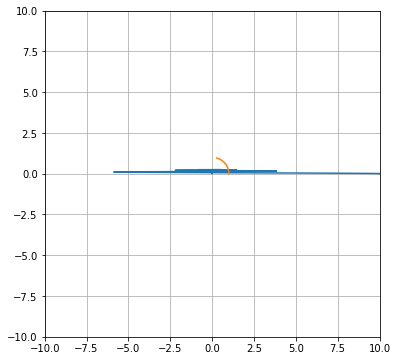

In [102]:
print(len(Xchaser[0]))
plt.figure(figsize=[6,6])
chaserx = [Xchaser[i][0,0] for i in range(len(Xchaser))]
chasery = [Xchaser[i][1,0] for i in range(len(Xchaser))]
portx = [Xport[i,0] for i in range(len(Xport))]
porty = [Xport[i,1] for i in range(len(Xport))]
plt.plot(chaserx,chasery)
plt.plot(portx,porty)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.grid()
plt.show()

In [103]:
animlen = len(chaserx)
squaresize = 20
fig = go.Figure(
    data=[go.Scatter(x=[chaserx[0], None, portx[0]], y=[chasery[0], None, porty[0]])],
    layout=go.Layout(
        xaxis=dict(range=[-squaresize, squaresize], autorange=False),
        yaxis=dict(range=[-squaresize, squaresize], autorange=False),
        title="Start Title",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None, {"frame": {"duration": 10, "redraw": True},}])])]
    ),
    frames=[go.Frame(data=[go.Scatter(x=[chaserx[i], None, portx[i]],y=[chasery[i], None, porty[i]])]) for i in range(1,animlen)]
)

fig.show()

In [49]:
def mapFeasibility():
    # discretize the space
    # run a sim from the true state without noise to see if the controller yields a spiral that is feasible
    # save the feasibility in a matrix
    pass